# Transfer learning experiments

This notebook includes:
1) Implement a transfer learning from ImageNet > 13 diseases > 1 disease. 
2) Compared performance against ImageNet > 1 disease and ImageNet > MURA > 1 disease 

Results for disease corresponding to index 10.

## Imports & global variables

We choose `idx=10` because from previous experiments we have detected a strong signal and a sufficient amount of positive cases. 

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import sys; sys.path.append("..")
import warnings; warnings.filterwarnings('ignore')

from core import * 
from data_manipulation import Transform, RandomRotation, Flip, RandomCrop
from utils import save_model, load_model, lr_loss_plot
from architectures import DenseNet121
from train_functions import OptimizerWrapper, TrainingPolicy, FinderPolicy, validate_multilabel, lr_finder, validate_binary



seed = 42
r_pix = 8
IDX = 10
BATCH_SIZE = 16
EPOCHS = 10
TRANSFORMATIONS = [RandomRotation(arc_width=20), Flip(), RandomCrop(r_pix=r_pix)]
PRETRAINED = True
NORMALIZE = True # ImageNet
FREEZE = True
GRADUAL_UNFREEZING = True
DATA = '14diseases'


BASE_PATH = Path('../..')
PATH = BASE_PATH/'data'
# SAVE_DATA = BASE_PATH/'output/real_data_experiments/multilabel/results'
SAVE_DIRECTORY = BASE_PATH/'output/real_data_experiments/multilabel/13-lbls-model'
IMG_FOLDER = PATH/'ChestXRay-250'


# Labels overview - positive cases

In [2]:
train_df = pd.read_csv(PATH/"train_df.csv")
valid_df = pd.read_csv(PATH/"val_df.csv")
test_df = pd.read_csv(PATH/"test_df.csv")

In [102]:
def decode_labels(df_col):
    return np.array(list(map(np.array, df_col.str.split(' ')))).astype(int)

train_lbls = decode_labels(train_df.Label)
valid_lbls = decode_labels(valid_df.Label)
test_lbls = decode_labels(test_df.Label)

lbls = np.concatenate([train_lbls, valid_lbls, test_lbls])

print("%\n".join((np.round(100*lbls.sum(0)/lbls.shape[0],3)).astype(str)) + "%")

10.309%
2.476%
11.877%
17.743%
5.157%
5.647%
1.276%
4.729%
4.163%
2.054%
2.244%
1.504%
3.019%
0.202%


In [103]:
print("%\n".join((np.round(100*train_lbls.sum(0)/train_lbls.shape[0],3)).astype(str)) + "%")

9.54%
1.956%
9.946%
15.887%
4.678%
5.37%
1.006%
3.008%
3.319%
1.54%
1.642%
1.454%
2.574%
0.156%


In [104]:
def split_dfs():
    # partition on positive - negative cases of disease "idx"
    idx_pos = train_lbls[:,IDX].astype(bool)
    df_train_small_pos = train_df[idx_pos]

    # sub-partition random  in neg cases
    df_train_neg = train_df[~idx_pos].reset_index(drop=True)
    idx_subset = np.random.choice(len(df_train_neg), sum(idx_pos==1))
    df_train_small_neg = df_train_neg.loc[idx_subset,:]

    # big and small training set (pretrain from big to small)
    df_train_big = df_train_neg[~df_train_neg.index.isin(idx_subset)].reset_index(drop=True)
    df_train_small = pd.concat([df_train_small_pos, df_train_small_neg], ignore_index=True).reset_index(drop=True)
    
    # save
    df_train_big.to_csv('train_df_big.csv', index=False)
    df_train_small.to_csv('train_df_small.csv', index=False)

# split_dfs()

## Mean & std

We are **not going to need that** because for both MURA and ImageNet were normalized with ImageNet. Therefore the downstream tasks should also be normalized with ImageNet.

In [136]:
train_df = pd.read_csv('train_df_big.csv')
def get_stats(df):
    means = []
    stds = []
    for file in tqdm_notebook(df.ImageIndex):
        path =  IMG_FOLDER/ file
        x = cv2.imread(str(path)).astype(np.float32)
        x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB) / 255
        means.append(x.mean(-1))
        stds.append(x.std(-1))
    return np.mean(means), np.mean(stds)

# mean, std = get_stats(train_df)

A Jupyter Widget

# Pre-train on 13 labels

## Development

In [108]:
class ChestXray13DataSet(Dataset):
    """
    Basic Images DataSet

    Args:
        dataframe with data: image_file, label
    """

    def __init__(self, df, image_path, idx):
        self.image_files = df["ImageIndex"].values
        # self.labels = df["Label"].values
        self.lables = np.array([[disease for i,disease in enumerate(obs.split(" ")) if i!=idx]
                                for obs in df["Label"].values]).astype(np.float32)
        self.image_path = image_path

    def __getitem__(self, index):
        path = self.image_path / self.image_files[index]
        x = cv2.imread(str(path)).astype(np.float32)
        x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB) / 255
        y = self.lables[index]
        return x, y

    def __len__(self):
        return len(self.image_files)
    
class DataBatches:
    '''
    Creates a dataloader using the specificed data frame with the dataset corresponding to "data".
    '''

    def __init__(self, df, idx, transforms, shuffle, img_folder_path, batch_size=16, num_workers=8,
                 drop_last=False, r_pix=8, normalize=True, seed=42):

        self.dataset = Transform(ChestXray13DataSet(df, image_path=img_folder_path, idx=idx),
                                 transforms=transforms, normalize=normalize, seed=seed, r_pix=r_pix)
        self.dataloader = DataLoader(
            self.dataset, batch_size=batch_size, num_workers=num_workers, pin_memory=True,
            shuffle=shuffle, drop_last=drop_last
        )
       

    def __iter__(self): return ((x.cuda().float(), y.cuda().float()) for (x, y) in self.dataloader)

    def __len__(self): return len(self.dataloader)

    def set_random_choices(self):
        if hasattr(self.dataset, "set_random_choices"): self.dataset.set_random_choices()

# test
# ds = ChestXray13DataSet(train_df, IMG_FOLDER, idx=0)
# ds[3][1].shape

In [109]:
train_dl = DataBatches(df=df_train_big, idx=IDX, transforms=TRANSFORMATIONS, shuffle=True,
                       img_folder_path=IMG_FOLDER, batch_size=BATCH_SIZE, 
                       r_pix=r_pix, normalize=NORMALIZE, seed=seed)

valid_dl = DataBatches(df=valid_df, idx=IDX, transforms=None, shuffle=False,
                       img_folder_path=IMG_FOLDER, batch_size=BATCH_SIZE, 
                       r_pix=r_pix, normalize=NORMALIZE, seed=seed)

test_dl = DataBatches(df=test_df, idx=IDX, transforms=TRANSFORMATIONS, shuffle=False, 
                      img_folder_path=IMG_FOLDER, batch_size=BATCH_SIZE, 
                      r_pix=r_pix, normalize=NORMALIZE, seed=seed)

A Jupyter Widget

A Jupyter Widget

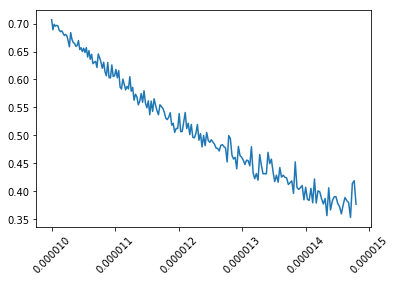

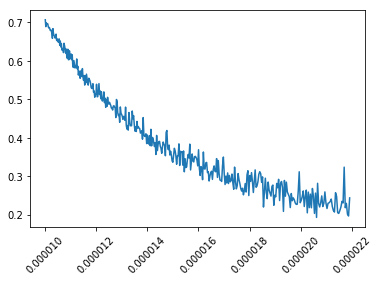

In [110]:
m = DenseNet121(out_size=13, pretrained=PRETRAINED, freeze=False).cuda()
lrs, losses = lr_finder(m, n_epochs=1, train_dl=train_dl, min_lr=.1e-4, early_stopping=500)

In [ ]:
def cos_annealing(start_lr, end_lr, n_iterations):
    i = np.arange(n_iterations)
    c_i = 1 + np.cos(i * np.pi / n_iterations)
    return end_lr + (start_lr - end_lr) / 2 * c_i

class TrainingPolicy:
    '''Cretes the lr and momentum policy'''

    def __init__(self, n_epochs, dl, max_lr, pctg=.3, moms=(.95, .85),
                 delta=1e-4, div_factor=25.):
        
        total_iterations = n_epochs * len(dl)

        iter1 = int(total_iterations * pctg)
        iter2 = total_iterations - int(total_iterations * pctg)
        iterations = (iter1, iter2)

        min_start = max_lr / div_factor
        min_end = min_start * delta

        lr_segments = ((min_start, max_lr), (max_lr, min_end))
        mom_segments = (moms, (moms[1], moms[0]))

        self.lr_schedule = self._create_schedule(lr_segments, iterations)
        self.mom_schedule = self._create_schedule(mom_segments, iterations)

        self.idx = -1

    def _create_schedule(self, segments, iterations):
        '''
        Creates a schedule given a function, behaviour and size
        '''
        stages = [cos_annealing(start, end, n) for ((start, end), n) in zip(segments, iterations)]
        return np.concatenate(stages)

    def step(self):
        self.idx += 1
        return self.lr_schedule[self.idx], self.mom_schedule[self.idx]
    
def train(n_epochs, train_dl, valid_dl, model, max_lr=.01, wd=0, alpha=1./ 3,
          save_path=None, unfreeze_during_loop:tuple=None):
    
    if unfreeze_during_loop:
        total_iter = n_epochs*len(train_dl)
        first_unfreeze = int(total_iter*unfreeze_during_loop[0])
        second_unfreeze = int(total_iter*unfreeze_during_loop[1])

    best_loss = np.inf
    cnt = 0
    
    policy = TrainingPolicy(n_epochs=n_epochs, dl=train_dl, max_lr=max_lr)
    optimizer = OptimizerWrapper(model, policy, wd=wd, alpha=alpha)

    for epoch in tqdm_notebook(range(n_epochs), ):
        model.train()
        agg_div = 0
        agg_loss = 0
        train_dl.set_random_choices()
        for x, y in tqdm_notebook(train_dl, leave=False):

            if unfreeze_during_loop:
                if cnt == first_unfreeze: model.unfreeze(1)
                if cnt == second_unfreeze: model.unfreeze(0)

            out = model(x)
            loss = F.binary_cross_entropy_with_logits(input=out, target=y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            batch = y.shape[0]
            agg_loss += batch*loss.item()
            agg_div += batch
            cnt += 1


        val_loss, measure, _ = validate_multilabel(model, valid_dl)
        print(f'Ep. {epoch+1} - train loss {agg_loss/agg_div:.4f} -  val loss {val_loss:.4f} AUC {measure:.4f}')

        if save_path and val_loss < best_loss:
            save_model(model, save_path)
            best_loss = val_loss

In [ ]:
# transforms=[RandomRotation(arc_width=20), Flip(), RandomCrop(r_pix=8)]

# train_dl = DataBatches(train_df, img_folder_path=img_folder_path,transforms=transforms,
#                        shuffle=True, data=data, batch_size=batch_size, normalize=pretrained)

model = DenseNet121(13, pretrained=PRETRAINED, freeze=FREEZE).cuda()
train(EPOCHS, train_dl, valid_dl, model, max_lr=.001, save_path=None, 
      unfreeze_during_loop=(.1, .2) if FREEZE else None)

## Script

In [37]:
%%writefile 13disease_upstream.py

import sys; sys.path.append("..")
import warnings; warnings.filterwarnings('ignore')

from core import * 
from data_manipulation import Transform, RandomRotation, Flip, RandomCrop
from utils import save_model, load_model, lr_loss_plot
from architectures import DenseNet121
from train_functions import OptimizerWrapper, validate_multilabel, TTA_multilabel

seed = 42
r_pix = 8
IDX = 10
BATCH_SIZE = 16
EPOCHS = 10
TRANSFORMATIONS = [RandomRotation(arc_width=20), Flip(), RandomCrop(r_pix=r_pix)]
PRETRAINED = NORMALIZE = True # ImageNet
FREEZE = True
GRADUAL_UNFREEZING = True
DATA = '14diseases'

BASE_PATH = Path('../..')
PATH = BASE_PATH/'data'
# SAVE_DATA = BASE_PATH/'output/real_data_experiments/multilabel/results'
SAVE_DIRECTORY = BASE_PATH/'output/real_data_experiments/multilabel/13-lbls-model'
IMG_FOLDER = PATH/'ChestXRay-250'

##### < --- Data set / loader ---> #####
class ChestXray13DataSet(Dataset):
    """
    Basic Images DataSet.
    
    Removes the label corresponding to the passed idx

    Args:
        dataframe with data: image_file, label
    """

    def __init__(self, df, image_path, idx):
        self.image_files = df["ImageIndex"].values
        # self.labels = df["Label"].values
        self.lables = np.array([[disease for i,disease in enumerate(obs.split(" ")) if i!=idx]
                                for obs in df["Label"].values]).astype(np.float32)
        self.image_path = image_path

    def __getitem__(self, index):
        path = self.image_path / self.image_files[index]
        x = cv2.imread(str(path)).astype(np.float32)
        x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB) / 255
        y = self.lables[index]
        return x, y

    def __len__(self):
        return len(self.image_files)
    
class DataBatches:
    '''
    Creates a dataloader using the specificed data frame with the dataset corresponding to "data".
    '''

    def __init__(self, df, idx, transforms, shuffle, img_folder_path, batch_size=16, num_workers=8,
                 drop_last=False, r_pix=8, normalize=True, seed=42):

        self.dataset = Transform(ChestXray13DataSet(df, image_path=img_folder_path, idx=idx),
                                 transforms=transforms, normalize=normalize, seed=seed, r_pix=r_pix)
        self.dataloader = DataLoader(
            self.dataset, batch_size=batch_size, num_workers=num_workers, pin_memory=True,
            shuffle=shuffle, drop_last=drop_last
        )
       

    def __iter__(self): return ((x.cuda().float(), y.cuda().float()) for (x, y) in self.dataloader)

    def __len__(self): return len(self.dataloader)

    def set_random_choices(self):
        if hasattr(self.dataset, "set_random_choices"): self.dataset.set_random_choices()

            
##### < --- Training ---> #####

def cos_annealing(start_lr, end_lr, n_iterations):
    i = np.arange(n_iterations)
    c_i = 1 + np.cos(i * np.pi / n_iterations)
    return end_lr + (start_lr - end_lr) / 2 * c_i

class TrainingPolicy:
    '''Cretes the lr and momentum policy'''

    def __init__(self, n_epochs, dl, max_lr, pctg=.3, moms=(.95, .85),
                 delta=1e-4, div_factor=25.):
        
        total_iterations = n_epochs * len(dl)

        iter1 = int(total_iterations * pctg)
        iter2 = total_iterations - int(total_iterations * pctg)
        iterations = (iter1, iter2)

        min_start = max_lr / div_factor
        min_end = min_start * delta

        lr_segments = ((min_start, max_lr), (max_lr, min_end))
        mom_segments = (moms, (moms[1], moms[0]))

        self.lr_schedule = self._create_schedule(lr_segments, iterations)
        self.mom_schedule = self._create_schedule(mom_segments, iterations)

        self.idx = -1

    def _create_schedule(self, segments, iterations):
        '''
        Creates a schedule given a function, behaviour and size
        '''
        stages = [cos_annealing(start, end, n) for ((start, end), n) in zip(segments, iterations)]
        return np.concatenate(stages)

    def step(self):
        self.idx += 1
        return self.lr_schedule[self.idx], self.mom_schedule[self.idx]
    
def train(n_epochs, train_dl, valid_dl, model, max_lr=.01, wd=0, alpha=1./ 3,
          save_path=None, unfreeze_during_loop:tuple=None):
    
    if unfreeze_during_loop:
        total_iter = n_epochs*len(train_dl)
        first_unfreeze = int(total_iter*unfreeze_during_loop[0])
        second_unfreeze = int(total_iter*unfreeze_during_loop[1])

    best_loss = np.inf
    cnt = 0
    
    policy = TrainingPolicy(n_epochs=n_epochs, dl=train_dl, max_lr=max_lr)
    optimizer = OptimizerWrapper(model, policy, wd=wd, alpha=alpha)

    for epoch in range(n_epochs):
        model.train()
        agg_div = 0
        agg_loss = 0
        train_dl.set_random_choices()
        for x, y in train_dl:

            if unfreeze_during_loop:
                if cnt == first_unfreeze: model.unfreeze(1)
                if cnt == second_unfreeze: model.unfreeze(0)

            out = model(x)
            loss = F.binary_cross_entropy_with_logits(input=out, target=y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            batch = y.shape[0]
            agg_loss += batch*loss.item()
            agg_div += batch
            cnt += 1


        val_loss, measure, _ = validate_multilabel(model, valid_dl)
        print(f'Ep. {epoch+1} - train loss {agg_loss/agg_div:.4f} -  val loss {val_loss:.4f} AUC {measure:.4f}')

        if save_path and val_loss < best_loss:
            save_model(model, save_path)
            best_loss = val_loss

            
train_df = pd.read_csv('train_df_big.csv') # train on big (no positive imgs of "idx")
valid_df = pd.read_csv(PATH/"val_df.csv")
test_df = pd.read_csv(PATH/"test_df.csv")

train_dl = DataBatches(df=train_df, idx=IDX, transforms=TRANSFORMATIONS, shuffle=True,
                       img_folder_path=IMG_FOLDER, batch_size=BATCH_SIZE, 
                       r_pix=r_pix, normalize=NORMALIZE, seed=seed)

valid_dl = DataBatches(df=valid_df, idx=IDX, transforms=None, shuffle=False,
                       img_folder_path=IMG_FOLDER, batch_size=BATCH_SIZE, 
                       r_pix=r_pix, normalize=NORMALIZE, seed=seed)

test_dl = DataBatches(df=test_df, idx=IDX, transforms=TRANSFORMATIONS, shuffle=False, 
                      img_folder_path=IMG_FOLDER, batch_size=BATCH_SIZE, 
                      r_pix=r_pix, normalize=NORMALIZE, seed=seed)

model = DenseNet121(13, pretrained=PRETRAINED, freeze=FREEZE).cuda()

model_p = SAVE_DIRECTORY/'model-minus-idx10.pth'
train(EPOCHS, train_dl, valid_dl, model, max_lr=.001, save_path=model_p, 
      unfreeze_during_loop=(.1, .2) if FREEZE else None)

print('\nTesting the model...')
load_model(model, model_p)

TTA_multilabel(model, test_dl)

Overwriting train_13_labels.py
